In [1]:
from os.path import join
import numpy as np
import pandas as pd
import json
import h5py
import re
from bids import BIDSLayout
import os

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import neurokit2 as nk
from scipy.signal import find_peaks
from scipy.stats import circmean, bootstrap
from functools import partial

In [2]:
layout = BIDSLayout('bids_dataset')

In [3]:
def read_ecg(sub, run):
    '''
    reads ECG data (and corresponsing stimulus timeseries)  
    from BIDS data directory
    '''
    fpaths = layout.get(
        return_type = 'file', 
        subject = sub, 
        run = run, 
        suffix = 'physio'
    )
    with open(fpaths[0], 'r') as f:
        info = json.load(f)
    df = pd.read_csv(fpaths[1], sep = '\t', header = None)
    df.columns = info['Columns']
    df['time'] = df.index * 1/info['SamplingFrequency']
    return df, info['SamplingFrequency']
    

In [4]:
df, fs = read_ecg('02', 2)
df.head()

,ecg,synchronous,asynchronous,time
0,-28.304309,0.923116,0.000021,0.00
1,-28.260852,0.854875,0.000044,0.01
2,-28.204346,0.771669,0.000089,0.02
3,-28.279387,0.678955,0.000175,0.03
4,-28.295904,0.582282,0.000335,0.04


In [5]:
def process_ecg(physio, fs):
    '''
    computer cardiace phase for each sample, return that and the cleaned signal
    '''
    signals, info = nk.ecg_process(physio.ecg, sampling_rate = fs, method = 'neurokit')
    phase_type = signals['ECG_Phase_Ventricular'].copy()
    phase = signals['ECG_Phase_Completion_Ventricular'].copy()
    phase[phase_type == 1.] = (1 - phase[phase_type == 1.])*-1
    phase *= np.pi
    return signals.ECG_Clean, phase

df['ecg_clean'], df['phase'] = process_ecg(df, fs)

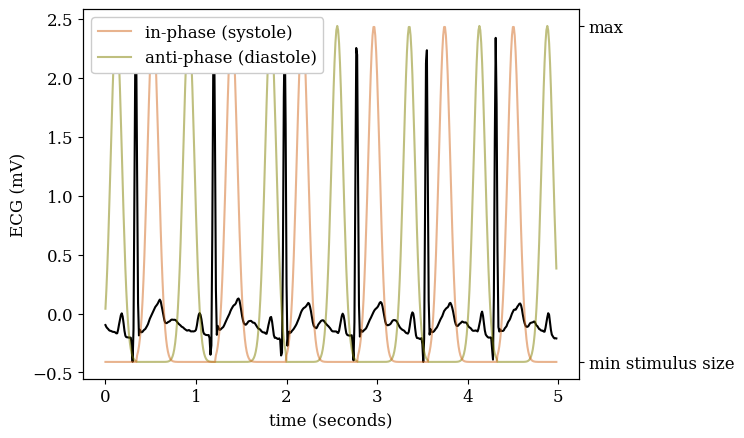

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

def plot_physio_sample(ax1, physio, start_t = 1*60, end_t = 1*60+5):

    ph = physio[(physio.time > physio.time[0] + start_t) \
                & (physio.time < physio.time[0] + end_t)]
    time = ph.time - ph.time.iloc[0]
    ax1.plot(time, ph.ecg_clean, color = 'black', label = 'ECG', zorder = 10)
    ax1.set_xlabel('time (seconds)')
    ax1.set_ylabel('ECG (mV)')
    

    ax2 = ax1.twinx()
    ax2.plot(
        time, ph.synchronous, 
        alpha = .5, zorder = 5,
        label = 'in-phase (systole)',
        color = 'chocolate'
    )
    ax2.plot(
        time, ph.asynchronous, 
        alpha = .5, zorder = 0,
        label = 'anti-phase (diastole)',
        color = 'olive'
    )
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['min stimulus size', 'max'])
    ax2.legend(loc = 'upper left', framealpha = 1.)

    return ax1, ax2

fig, ax = plt.subplots()
plot_physio_sample(ax, df)
plt.show()

In [7]:
def get_phase_at_peaks(physio):
    '''
    computes cardiac angle, scaled such that R peak is always at pi radians,  
    the the T wave always ends at 0 radians. Thus, angles on the bottom of
    the unit circle are all in systole and top are in diastole. 
    '''
    peak_idxs = find_peaks(physio.synchronous)[0]
    phase_at_peaks_sync = physio.phase[peak_idxs]
    peak_idxs = find_peaks(physio.asynchronous)[0]
    phase_at_peaks_async = physio.phase[peak_idxs]
    return phase_at_peaks_sync[1:-1], phase_at_peaks_async[1:-1]

phase_sync, phase_async = get_phase_at_peaks(df)

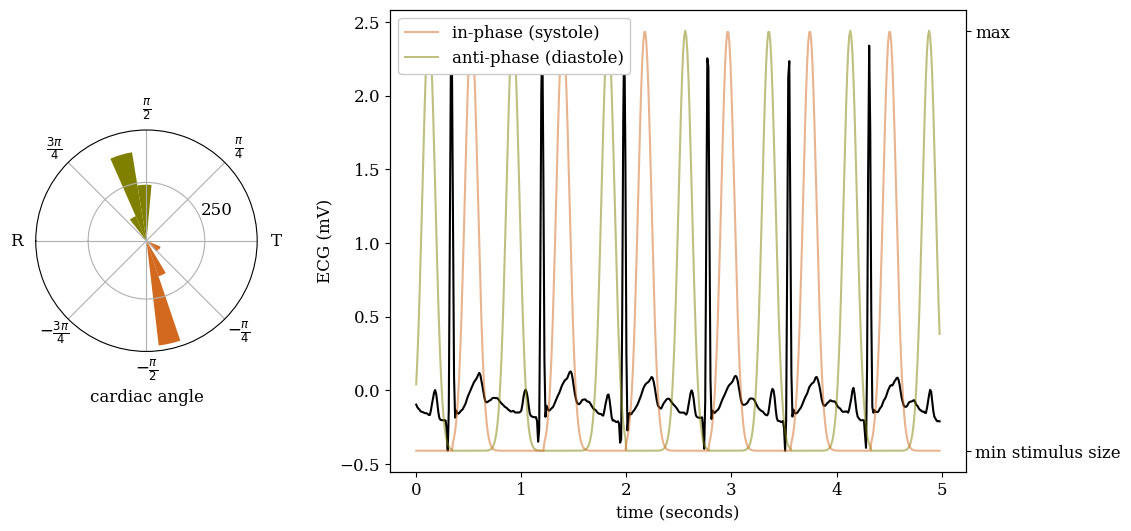

In [8]:
fig = plt.figure(figsize = (12, 6))
gs = gridspec.GridSpec(1, 3, wspace = .6)
ax0 = fig.add_subplot(gs[:, 1:])
plot_physio_sample(ax0, df)

ax = fig.add_subplot(gs[:, 0], projection = 'polar')
ax.hist(phase_sync, bins = 15, label = 'in-phase', color = 'chocolate')
ax.hist(phase_async, bins = 15, label = 'anti-phase', color = 'olive')
ticks = np.linspace(np.pi,  -np.pi, 8, endpoint = False)
tick_labels = [
    r'R', 
    r'$\frac{3\pi}{4}$', 
    r'$\frac{\pi}{2}$', 
    r'$\frac{\pi}{4}$', 
    r'T',
    r'$-\frac{\pi}{4}$', 
    r'$-\frac{\pi}{2}$',
    r'$-\frac{3\pi}{4}$'
]
# set radian ticks
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_thetalim(-np.pi, np.pi)
ax.set_xlabel('cardiac angle')
# adjust r ticks
#ax.set_rlabel_position(90 + 45)
tick_max = ax.get_rmax() - (ax.get_rmax() % 250)
ticks = np.arange(250, tick_max + 1, step = 250) 
ax.set_rticks(ticks)

def add_label(ax, label, x_offset = .1):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - x_offset * xscale, ymax - .05 * yscale, 
        label, size = 20, weight = 'bold'
    )

#add_label(ax0, 'a', .12)
#add_label(ax0, 'b', -1.1)

fpath = join('figures', 'cardio-illustration.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

In [9]:
def get_bootstrap_dist(phases):
    mean = partial(circmean, high = np.pi, low = -np.pi)
    res = bootstrap([phases], mean, confidence_level = .95, random_state = 0)
    return res.bootstrap_distribution

def bootstrap_angles(sub):
    '''
    combines cardiac angles across runs within a single subject,
    and then samples the bootstrap distributon of their mean
    '''
    phase_sync, phase_async = [], []
    for run in range(1, 3):
        df, fs = read_ecg(sub, run)
        df['ecg_clean'], df['phase'] = process_ecg(df, fs)
        _phase_sync, _phase_async = get_phase_at_peaks(df)
        phase_sync.append(_phase_sync)
        phase_async.append(_phase_async)
    phase_sync, phase_async = np.concatenate(phase_sync), np.concatenate(phase_async)
    ps, pa = get_bootstrap_dist(phase_sync), get_bootstrap_dist(phase_async)
    return ps, pa

In [10]:
# bootstrap mean cardiac angles for each subject
if not os.path.exists('sync.npy'):
    phase_sync, phase_async = [], []
    for sub in layout.get_subjects():
        print('starting subject %s...'%sub)
        _sync, _async = bootstrap_angles(sub)
        phase_sync.append(_sync)
        phase_async.append(_async)
    phase_sync = np.stack(phase_sync)
    np.save('sync.npy', phase_sync)
    phase_async = np.stack(phase_async)
    np.save('async.npy', phase_async)
else:
    phase_sync = np.load('sync.npy')
    phase_async = np.load('async.npy')

In [11]:
# check if all sub's sync stim occured during systole
(circmean(phase_sync, high = np.pi, low = -np.pi, axis = 1)  < 0).mean() 

1.0

In [12]:
# check if all async stim occured during diastole
(circmean(phase_async, high = np.pi, low = -np.pi, axis = 1) > 0).mean() 

1.0

In [13]:
# group-level bootrap from subject-level samples
cmean =  partial(circmean, high = np.pi, low = -np.pi)
subsample = 1000 # for memory efficiency, will still have default # of group samples (i.e. 10,000)
res = bootstrap([phase_sync[:, :subsample]], cmean, vectorized = True, axis = 0, random_state = 1)
group_mean_dist_sync = cmean(res.bootstrap_distribution, axis = 0)
res = bootstrap([phase_async[:, :subsample]], cmean, vectorized = True, axis = 0, random_state = 2)
group_mean_dist_async = cmean(res.bootstrap_distribution, axis = 0)

In [14]:
def print_summary_stats(bd):
    # average samplewise across subs for multilevel bootstrap
    m = circmean(bd, high = np.pi, low = -np.pi) 
    lower, upper = np.quantile(bd, [.025, .975])
    print('Mean: %.03f, 95%% CI: [%.03f, %.03f]'%(m, lower, upper))

print('In-phase stimulus:')
print_summary_stats(group_mean_dist_sync)
print('\nAnti-phase stimulus:')
print_summary_stats(group_mean_dist_async)

In-phase stimulus:
Mean: -1.042, 95% CI: [-1.096, -0.987]

Anti-phase stimulus:
Mean: 1.928, 95% CI: [1.882, 1.975]
